# Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pySODM.models.base import ODEModel
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.TDPF import ramp_fun
from covid19_DTM.models.TDPF import make_seasonality_function
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader
from matplotlib import font_manager
import string
import os

# Data

In [2]:
abs_dir = os.getcwd()
rel_dir = '../../data/PHM/interim/UZG/'
file_name = 'MZG_residence_times.csv'

types_dict = {'APR_MDC_key': str, 'age_group': str, 'stay_type':str}
residence_times = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()
mean_residence_times = residence_times.groupby(by=['APR_MDC_key']).mean()

file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
hospitalization_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
hospitalization_baseline = hospitalization_baseline.groupby(['APR_MDC_key','week_number','day_number']).mean()
hospitalization_baseline = hospitalization_baseline.ewm(7).mean()

file_name = 'MZG_Hospitalizations_per_day_before.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_before = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name = 'MZG_Hospitalizations_per_day_covid.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_covid = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()

file_name ='MZG_Hospitalizations_per_day_baseline.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_per_day_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()

file_name = 'MZG_covid_hospitalizations_per_day.csv'
types_dict = {'APR_MDC_key': str}
covid_hospitalizations_per_day = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0],dtype=types_dict).squeeze()*2
#covid_hospitalizations_per_day -= 4
#covid_hospitalizations_per_day[np.where(covid_hospitalizations_per_day<0)[0]]=0

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})
MDC_dict.update({'covid':'covid'})

MDC_keys = hospitalization_baseline.index.get_level_values(0).unique().values
MDC_keys = np.append(MDC_keys,'covid')
mean_residence_times['covid']=10

covid_data, _ , _ , _ = get_sciensano_COVID19_data(update=False)
new_index = pd.MultiIndex.from_product([pd.date_range('2016-01-01','2022-01-01'),covid_data.index.get_level_values('NIS').unique()])
covid_data = covid_data.reindex(new_index,fill_value=0)
df_covid_H_in = covid_data['H_in'].loc[:,40000]
df_covid_H_tot = covid_data['H_tot'].loc[:,40000]
df_covid_H_in = df_covid_H_in.ewm(7).mean()


In [3]:
hospitalization_baseline

APR_MDC_key  week_number  day_number
00           1            1             27.274000
                          2             28.546533
                          3             30.715136
                          4             32.255626
                          5             32.587795
                                          ...    
PP           53           3             23.762928
                          4             23.776812
                          5             23.554711
                          6             23.360372
                          7             23.190325
Name: n_patients, Length: 10388, dtype: float64

<AxesSubplot:xlabel='week_number,day_number'>

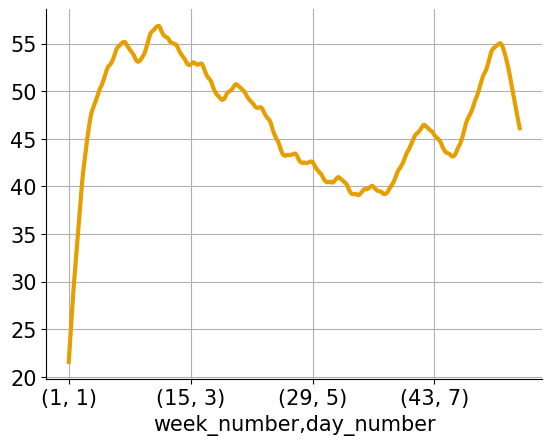

In [4]:
hospitalization_baseline.loc['04'].ewm(7).mean().plot()

<AxesSubplot:xlabel='week_number,day_number'>

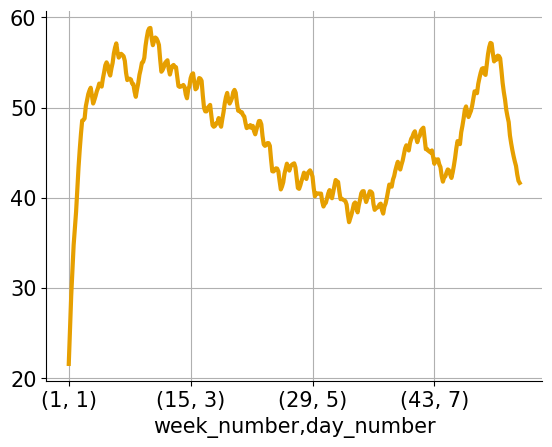

In [5]:
hospitalization_baseline.loc['04'].plot()

# Define model and functions

In [177]:
class postponed_healthcare_model(ODEModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['W','H','R','NR','X']
    parameter_names = ['X_tot','f_UZG','covid_H']
    parameter_stratified_names = ['A','gamma','epsilon','sigma']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, W, H, R, NR, X, X_tot, f_UZG, covid_H, A, gamma, epsilon, sigma):
        X_new = ((X_tot-f_UZG*covid_H)-sum(H - (1/gamma*H))) * (sigma*(A+W))/sum(sigma*(A+W))

        W_to_H = np.where(W>X_new,X_new,W)
        W_to_NR = epsilon*(W-W_to_H)
        A_to_H = np.where(A>(X_new-W_to_H),(X_new-W_to_H),A)
        A_to_W = A-A_to_H
        
        dX = -X + X_new - W_to_H - A_to_H
        dW = A_to_W - W_to_H - W_to_NR
        dH = A_to_H + W_to_H - (1/gamma*H)
        dR = (1/gamma*H)
        dNR = W_to_NR
        
        return dW, dH, dR, dNR, dX

In [7]:
from functools import lru_cache

class get_A():
    def __init__(self, baseline,mean_residence_times):
        self.baseline = baseline
        self.mean_residence_times = mean_residence_times
    
    def A_wrapper_func(self, t, states, param, MDC):
        return self.__call__(t,MDC)
    
    #@lru_cache()
    def __call__(self, t, MDC):

        t_string = t.strftime('%Y-%m-%d')
        week = t.isocalendar().week
        day = t.isocalendar().weekday

        A = (self.baseline.loc[(MDC,week,day)]/self.mean_residence_times.loc[MDC]).values

        return A 

from functools import lru_cache
class get_covid_H():

    def __init__(self, data):
        self.data = data

    def H_wrapper_func(self, t, states, param):
        return self.__call__(t)

    @lru_cache()
    def __call__(self, t):
        t = pd.to_datetime(t).round(freq='D')
        try:
            covid_H = self.data.loc[t]
        except:
            covid_H = 0
        return covid_H 

In [8]:
def old_daily_hospitalizations_func(t, states, param,MDC):

    t_string = t.strftime('%Y-%m-%d')
    #if t_string in covid_hospitalizations_per_day.index.get_level_values(0).values:
        #covid_H = covid_hospitalizations_per_day.loc[t_string]
    #else:
        #covid_H=0
    if t >=pd.Timestamp('2020-01-01'):
        covid_H=covid_hospitalizations_per_day.loc[t_string]
    else:
        covid_H=0

    #week = t.isocalendar().week
    #day = t.isocalendar().weekday
    #daily_hospitalizations = hospitalizations_per_day_baseline.loc[MDC_keys[np.where(MDC_keys!='covid')],week,day].values
    #daily_hospitalizations = np.insert(daily_hospitalizations,np.where(MDC_keys=='covid')[0],covid_H)
    
    if t < pd.Timestamp('2020-01-01'):
        daily_hospitalizations = hospitalizations_per_day_before.loc[(MDC[np.where(MDC!='covid')],t_string)].values
    else:
        daily_hospitalizations = hospitalizations_per_day_covid.loc[(MDC[np.where(MDC!='covid')],t_string)].values
    daily_hospitalizations = np.insert(daily_hospitalizations,np.where(MDC=='covid')[0],covid_H)
    return daily_hospitalizations

In [9]:
def daily_hospitalizations_func(t, states, param,MDC,f_UZG):
    covid_idx = int(np.where(MDC=='covid')[0])
    MDC_without_covid = np.delete(MDC,covid_idx)

    t_string = t.strftime('%Y-%m-%d')
    week = t.isocalendar().week
    day = t.isocalendar().weekday

    A = (hospitalization_baseline.loc[(MDC_without_covid,week,day)]/mean_residence_times.loc[MDC_without_covid]).values
    covid_H_in = df_covid_H_in.loc[t_string]*f_UZG
    A = np.insert(A,covid_idx,covid_H_in)

    return A

In [30]:
start_peak = pd.to_datetime('2020-01-01')
end_peak = pd.to_datetime('2020-04-01')
peak_amplitude = 1000
x = pd.to_datetime('2020-03-01')

mu = start_peak + (end_peak - start_peak)/2
sigma = (end_peak - start_peak)/pd.Timedelta('1D') / 6  # Adjust the divisor for desired width

y = peak_amplitude * np.exp(-((x - mu)/pd.Timedelta('1D'))**2 / (2 * sigma**2))

In [31]:
y

633.1739937634176

In [227]:
def hypothetical_covid_peak(t, states, param,start_peak,end_peak,peak_amplitude):
    
    mu = start_peak + (end_peak - start_peak)/2
    sigma = (end_peak - start_peak)/pd.Timedelta('1D') / 4  # Adjust the divisor for desired width

    covid_H = peak_amplitude * np.exp(-((t - mu)/pd.Timedelta('1D'))**2 / (2 * sigma**2))
    
    #if t <= start_peak:
    #    covid_H = 0
    #elif start_peak < t <= start_peak+l_days/2:
    #    covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    #elif start_peak+l_days/2 < t <= end_peak:
    #    covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    #else:
    #    covid_H=0

    return covid_H


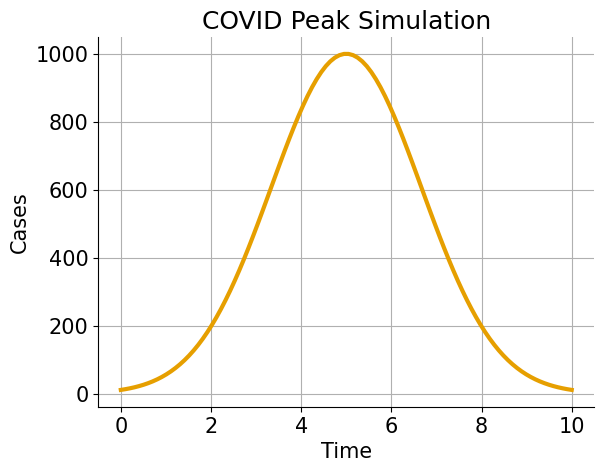

In [73]:
def covid_peak_simulation(start_peak, end_peak, peak_amplitude):
    x = np.linspace(start_peak, end_peak, num=100)  # Adjust the 'num' parameter for desired resolution
    mu = (start_peak + end_peak) / 2
    sigma = (end_peak - start_peak) / 6  # Adjust the divisor for desired width
    
    y = peak_amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))

    plt.plot(x, y)
    plt.xlabel('Time')
    plt.ylabel('Cases')
    plt.title('COVID Peak Simulation')
    plt.show()

# Example usage
covid_peak_simulation(0, 10, 1000)

# Conceptual example

In [109]:
start_sim = pd.to_datetime('2020-12-01')
end_sim = pd.to_datetime('2021-12-01')
sim_time = pd.date_range(start_sim,end_sim)

plot_start_date = pd.to_datetime('2021-01-01')
plot_end_date = pd.to_datetime('2021-12-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

start_peak = pd.to_datetime('2021-01-01')
end_peak = pd.to_datetime('2021-06-01')
peak_amplitude = 30

In [228]:
# Define MDC classes to model
MDC = np.array(['05'])

# Define model parameters, initial states and coordinates
gamma = np.ones(len(MDC))*10
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))

X_tot = 110

A = np.array([10])
params={'A':A,'f_UZG':0.5,'covid_H':0,'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 
'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude}

H_init = np.array([100])

init_states = {'H':H_init}
coordinates={'MDC':MDC}

covid_H_func = get_covid_H(df_covid_H_tot).H_wrapper_func
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_H':hypothetical_covid_peak})


In [229]:
out = model.sim([start_sim,end_sim],tau=1)

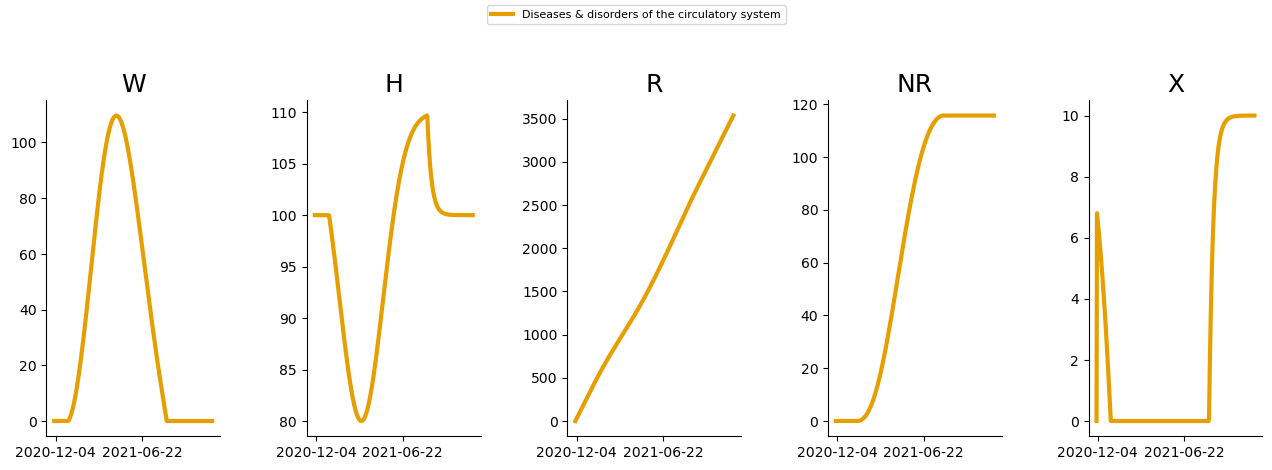

In [112]:
fig, axs = plt.subplots(1,5)
axs = axs.reshape(-1)

label_with = False
label_without = False
idx=0
for state in model.state_names:
    for disease in out.MDC.values:
        out_plot = out.sel(MDC=disease)[state]
        axs[idx].plot(sim_time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    idx+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

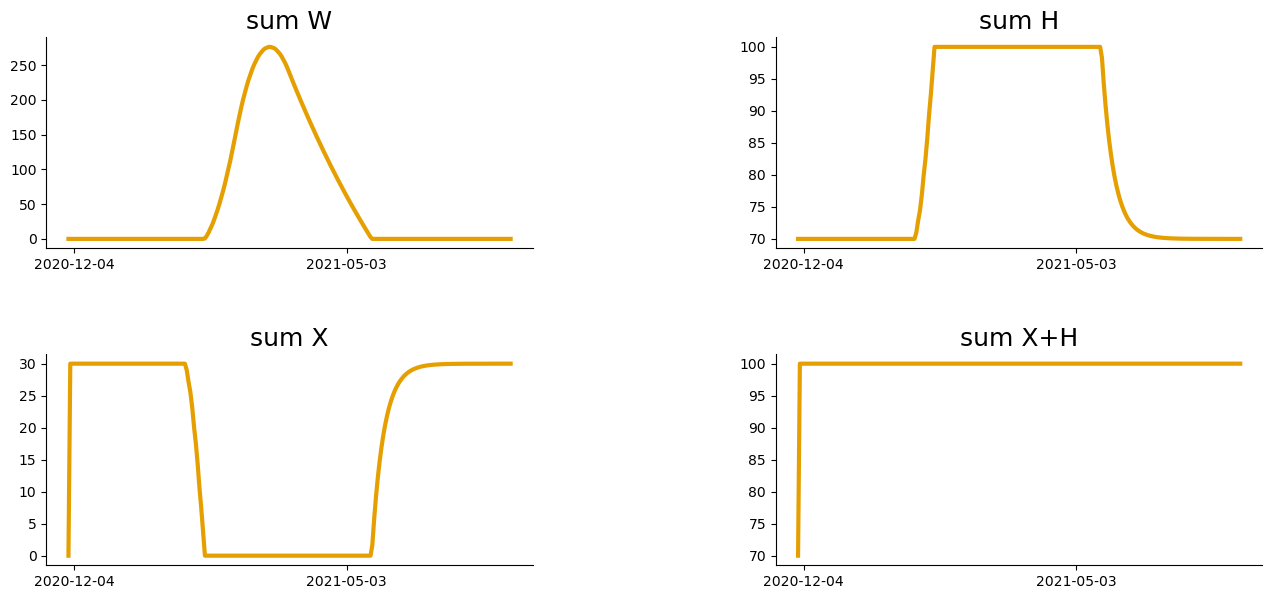

In [14]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state == 'X+H':
        out_plot = out.sum('MDC')['X'] + out.sum('MDC')['H']
    else:
        out_plot = out.sum('MDC')[state]
    axs[idx].plot(sim_time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_yticks

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

# Parameter influences 

In [178]:
abs_dir = os.getcwd()
result_folder = '../../results/PHM/analysis/queuing_model/parameter_influences/'

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=8)

In [240]:
start_sim = pd.to_datetime('2019-12-01')
end_sim = pd.to_datetime('2020-08-01')

plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2020-08-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

start_peak = pd.to_datetime('2020-02-01')
end_peak = pd.to_datetime('2020-05-01')
peak_amplitude = 150

In [241]:
# Define MDC classes to model
MDC = np.array(['03','05'])

# Define model parameters, initial states and coordinates
gamma = np.ones(len(MDC))*10
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))

X_tot = 250

A = np.array([10,10])
params={'A':A,'f_UZG':1,'covid_H':0,'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma, 
'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude}

H_init = np.array([100,100])

init_states = {'H':H_init}
coordinates={'MDC':MDC}

covid_H_func = get_covid_H(df_covid_H_tot).H_wrapper_func
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_H':hypothetical_covid_peak})

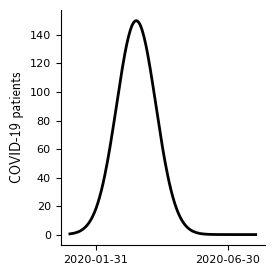

In [247]:
covid_H = []
for t in plot_time:
    mu = start_peak + (end_peak - start_peak)/2
    sigma = (end_peak - start_peak)/pd.Timedelta('1D') / 4  # Adjust the divisor for desired width

    covid_H.append(peak_amplitude * np.exp(-((t - mu)/pd.Timedelta('1D'))**2 / (2 * sigma**2)))

fig,ax = plt.subplots(figsize=(3,3))
ax.plot(plot_time,covid_H,color='black',linewidth=2)
ax.xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel('COVID-19 patients',font=label_font)
ax.grid(False)
fig.tight_layout()
fig.savefig(os.path.join(result_folder,f'hypothetical_covid_peak'),dpi=600,bbox_inches='tight')

In [243]:
sigma_individual_choices = [1/3,1,3]
sigma_choices = []
for sigma in sigma_individual_choices:
    sigma_choices.append(np.where(MDC=='03',sigma,1))

X_tot_choices = [200, 250, 300]

epsilon_non_covid_choices = [0,0.01,1]
epsilon_choices = []
for epsilon in epsilon_non_covid_choices:
    epsilon_choices.append(np.where(MDC!='covid',epsilon,0))

#beta_choices = [0.1,0.5,1]
#beta_choices = np.tile(beta_choices,(len(MDC),1)).transpose()

parameters = {'sigma':sigma_choices,'X_tot':X_tot_choices,'epsilon':epsilon_choices}

sigma
X_tot
epsilon
                         a                   b                   c
sigma    180.5558059751112  177.93208803678618  180.55580597511118
X_tot    629.6706721821431  177.93208803678618   32.83078194710278
epsilon                0.0  177.93208803678618   393.0097670510364


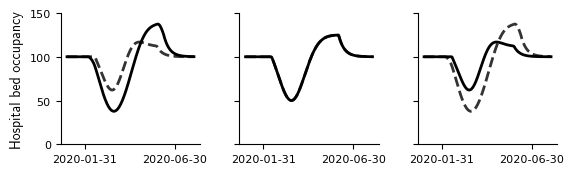

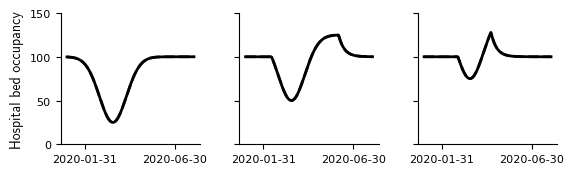

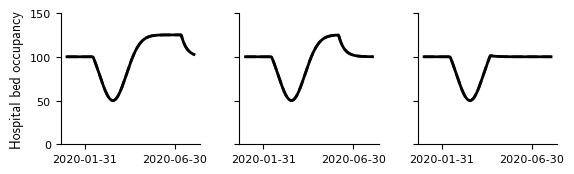

In [250]:
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_H':hypothetical_covid_peak})
NR_table = pd.DataFrame(index=parameters.keys(),columns=['a','b','c'])

for parameter_name,parameter_choices in parameters.items():
    fig, axs = plt.subplots(1,3,figsize=(6,2),sharey=True,sharex=True)
    print(parameter_name)
    for i,parameter_value in enumerate(parameter_choices):
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim],tau=1)
        NR_table[string.ascii_lowercase[i]][parameter_name]=out.NR[-1].sum().values
        for disease in MDC:
            out_plot = out.sel(MDC=disease,date=plot_time)['H']
            if disease == "05":
                axs[i].plot(plot_time,out_plot,color='black',linestyle='dashed',linewidth=2,alpha=0.8)
            else:
                axs[i].plot(plot_time,out_plot,color='black',linewidth=2)
            axs[i].set_ylim([0,150])
            #axs[i].set_title(f'{string.ascii_lowercase[i]})',font=label_font)
            axs[i].xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
            axs[i].tick_params(axis='both', which='major', labelsize=8)
            axs[i].grid(False)
    axs[0].set_ylabel('Hospital bed occupancy',font=label_font)
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'queuing_model_{parameter_name}'),dpi=600,bbox_inches='tight')
    model.parameters.update({parameter_name:globals()[parameter_name]})
print(NR_table)
NR_table.to_csv(os.path.join(result_folder,'NR_table.csv'))


# Fitting real world data

In [218]:
def normalize_model_output(out):
    multi_index = pd.MultiIndex.from_product([np.delete(MDC,MDC=='covid'),out.date.values])
    baseline = pd.Series(index=multi_index)
    for idx,(disease,date) in enumerate(multi_index):
        baseline[idx] = hospitalization_baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

    for disease in np.delete(MDC,MDC=='covid'):
            out.sel(MDC=disease)['H']=out.sel(MDC=disease)['H']/baseline.loc[disease]
    
    return out

In [23]:
def init_queuing_model(start_date):
    # Define model parameters, initial states and coordinates
    gamma =  mean_residence_times.loc[MDC].values
    epsilon = np.ones(len(MDC))*0.01
    epsilon[np.where(MDC=='covid')]=0
    sigma = np.ones(len(MDC))
    sigma[np.where(MDC=='covid')]=2

    f_UZG = 0.5
    X_tot = 1049

    t_string = start_date.strftime('%Y-%m-%d')
    covid_H_in = df_covid_H_in.loc[t_string]*f_UZG
    covid_H = df_covid_H_tot.loc[t_string]*f_UZG
    H_init = hospitalization_baseline.loc[(MDC,start_date.isocalendar().week,start_date.isocalendar().weekday)].values
    H_init = np.insert(H_init,np.where(MDC=='covid')[0],covid_H)
    A = H_init/mean_residence_times.loc[(MDC)]

    params={'A':A,'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,'MDC':MDC,'f_UZG':f_UZG}

    init_states = {'H':H_init}
    coordinates={'MDC':MDC}

    # Initialize model
    model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'A': daily_hospitalizations_func})

    return model

## Before Covid

### Parameters

In [25]:
#set start and end date
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2020-01-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

In [26]:
# Define MDC classes to model
MDC = hospitalizations_per_day_before.index.get_level_values('APR_MDC_key').unique().values
MDC = np.append(MDC,'covid')

# Define model parameters, initial states and coordinates
gamma = mean_residence_times.loc[MDC].values
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))
sigma[np.where(MDC=='covid')]=10

X_tot = 1049
#X_tot = 1400

A = hospitalizations_per_day_before.loc[(MDC,start_date.strftime('%Y-%m-%d'))].values
A = np.append(A,0)
params={'A':A,'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,'MDC':MDC,'f_UZG':0.5}

H_init = hospitalization_baseline.loc[MDC,start_date.isocalendar().week,start_date.isocalendar().weekday].values
H_init = np.insert(H_init,np.where(MDC=='covid')[0],0)
init_states = {'H':H_init}
coordinates={'MDC':MDC}
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'A': daily_hospitalizations_func})

C:\Users\wolfd\AppData\Local\Temp\ipykernel_14644\1217114678.py:14: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  A = hospitalizations_per_day_before.loc[(MDC,start_date.strftime('%Y-%m-%d'))].values
C:\Users\wolfd\AppData\Local\Temp\ipykernel_14644\1217114678.py:18: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  H_init = hospitalization_baseline.loc[MDC,start_date.isocalendar().week,start_date.isocalendar().weekday].values


In [28]:
def draw_func(param_dict,samples_dict):
    return param_dict

In [46]:
out_real_world_before = model.sim([start_date,end_date],tau=1)

In [30]:
out = out_real_world_before

In [33]:
disease='04'

In [37]:
out.sel(MDC=disease)['H'].values

array([[21.56698584, 21.56698584, 22.52627955, ..., 48.75850866,
        41.80607968, 37.59056713],
       [21.56698584, 21.56698584, 22.52627955, ..., 48.75850866,
        41.80607968, 37.59056713]])

In [56]:
out = out.copy()
multi_index = pd.MultiIndex.from_product([np.delete(MDC,MDC=='covid'),out.date.values])
baseline = pd.Series(index=multi_index)
for idx,(disease,date) in enumerate(multi_index):
    baseline[idx] = hospitalization_baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

if 'draws' in out.dims:
    for disease in np.delete(MDC,MDC=='covid'):
        for draw in out.draws:
            out.sel(MDC=disease,draws=draw)['H'][:]=out.sel(MDC=disease,draws=draw)['H']/baseline.loc[disease]
else:
    for disease in np.delete(MDC,MDC=='covid'):
        out.sel(MDC=disease)['H'][:]=out.sel(MDC=disease)['H']/baseline.loc[disease]

C:\Users\wolfd\AppData\Local\Temp\ipykernel_14644\1239999921.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline = pd.Series(index=multi_index)


In [52]:
'draws' in out_real_world_before.dims

False

In [53]:
out.sel(MDC='04',draws=1)

<xarray.Dataset>
Dimensions:  (date: 731)
Coordinates:
  * date     (date) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-01-01
    MDC      <U2 '04'
Data variables:
    W        (date) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    H        (date) float64 21.57 21.57 22.53 24.21 ... 49.69 48.76 41.81 37.59
    R        (date) float64 0.0 5.514 11.03 ... 8.789e+03 8.801e+03 8.812e+03
    NR       (date) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    X        (date) float64 0.0 9.581 10.85 11.54 ... 7.25 8.55 5.669 7.468

### plot results

In [ ]:
MDC_plot_classes = np.array(['05'])
plot_start_date = pd.to_datetime('2018-01-01')
plot_end_date = pd.to_datetime('2020-01-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_real_world_before.sel(date=time).copy()


#### States


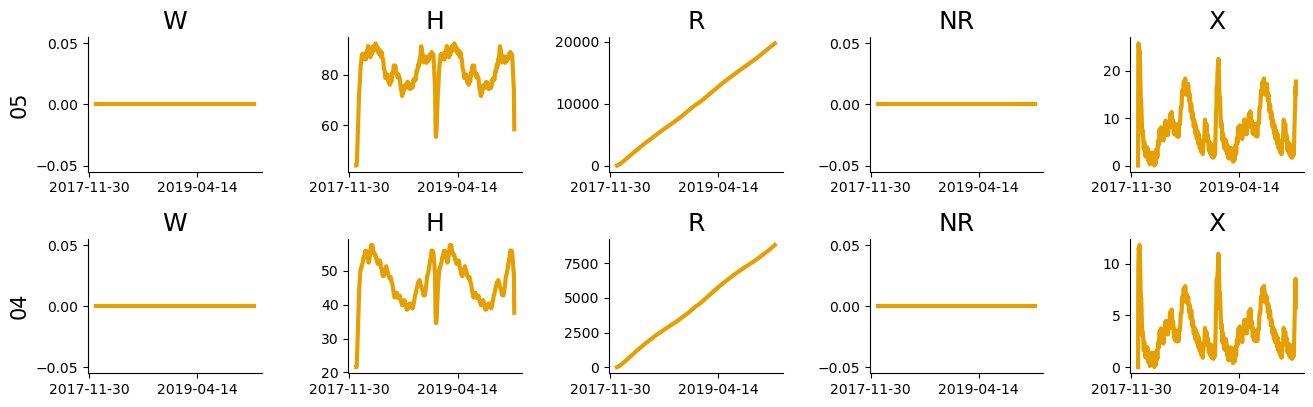

In [ ]:
fig, axs = plt.subplots(len(MDC_plot_classes),5)

for disease_idx, disease in enumerate(MDC_plot_classes):
    axs[disease_idx,0].set_ylabel(disease)
    for state_idx, state in enumerate(model.state_names):
        if disease=='04':
            out_plot = out.sel(MDC=disease)[state]+out.sel(MDC='covid')[state]
        else:
            out_plot = out.sel(MDC=disease)[state].copy()
        axs[disease_idx,state_idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[disease_idx,state_idx].set_title(state)
        axs[disease_idx,state_idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[disease_idx,state_idx].grid(False)
        axs[disease_idx,state_idx].tick_params(axis='both', which='major', labelsize=10)
        axs[disease_idx,state_idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)

#### Sum

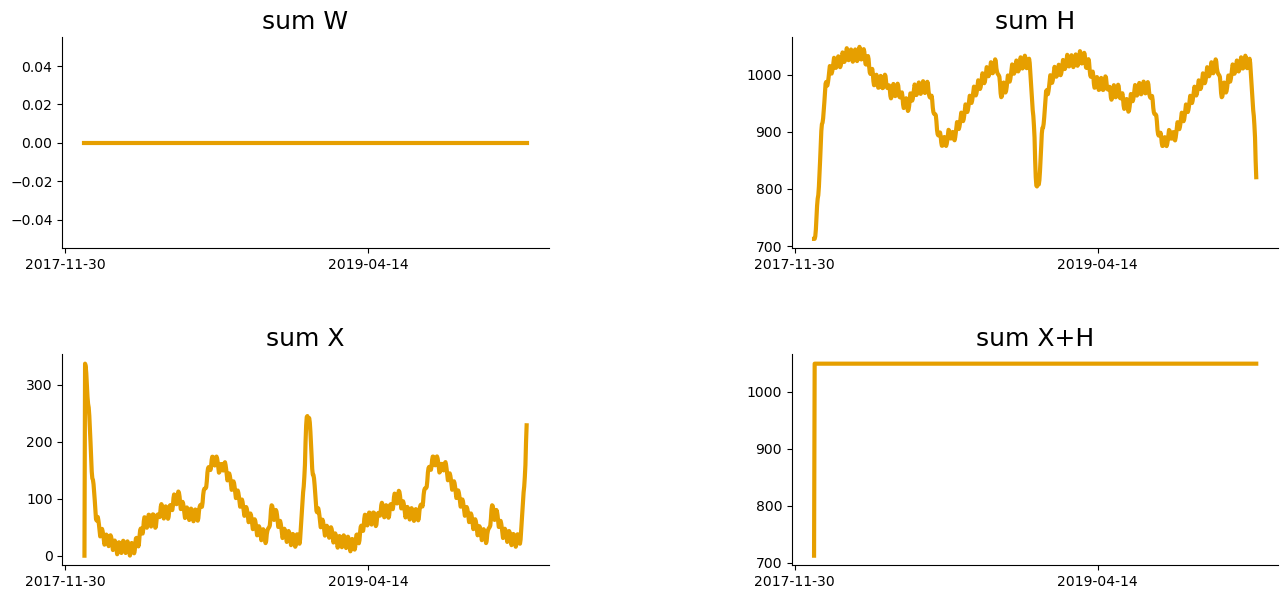

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state == 'X+H':
        out_plot = out.sum('MDC')['X'] + out.sum('MDC')['H']
    else:
        out_plot = out.sum('MDC')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
#axs[0].set_yticks(ticks=[X_tot-50,X_tot,X_tot+50])
plt.show()


#### normalized

C:\Users\wolfd\AppData\Local\Temp\ipykernel_3052\2892920409.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline = pd.Series(index=multi_index)


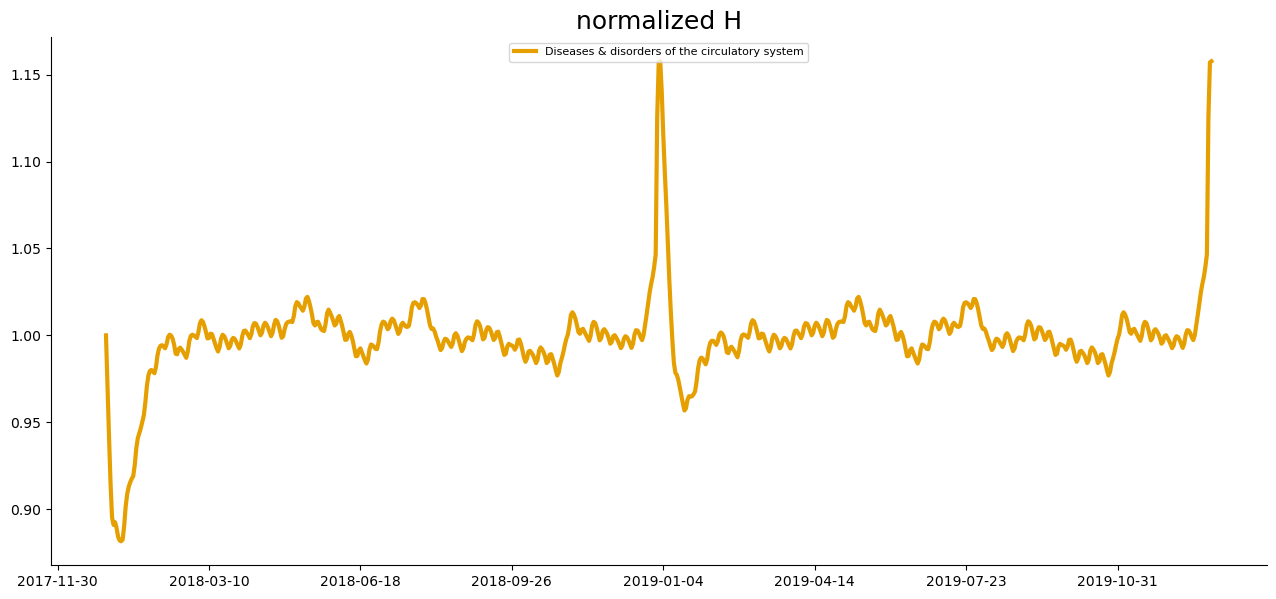

In [ ]:
fix,ax=plt.subplots()

multi_index = pd.MultiIndex.from_product([np.delete(MDC,MDC=='covid'),out.date.values])
baseline = pd.Series(index=multi_index)
for idx,(disease,date) in enumerate(multi_index):
    baseline[idx] = hospitalization_baseline.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

for disease in np.delete(MDC,MDC=='covid'):
        normalized = (out.sel(MDC=disease)['H']/baseline.loc[disease]).values
        out.sel(MDC=disease)['H'][:]=normalized

for disease in MDC_plot_classes:
    #if disease=='04':
    #    out_plot = out.sel(MDC=disease)['H']+out.sel(MDC='covid')['H'].values
    #else:
    out_plot = out.sel(MDC=disease)['H'].copy().values

    #for idx, t in enumerate(time):
    #    week=t.isocalendar().week
    #    day=t.isocalendar().weekday
    #    out_plot[idx] = out_plot[idx]/hospitalization_baseline.loc[disease,week,day]
    out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('normalized H')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

C:\Users\wolfd\AppData\Local\Temp\ipykernel_3052\3646748798.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out_plot = pd.Series(index=time)


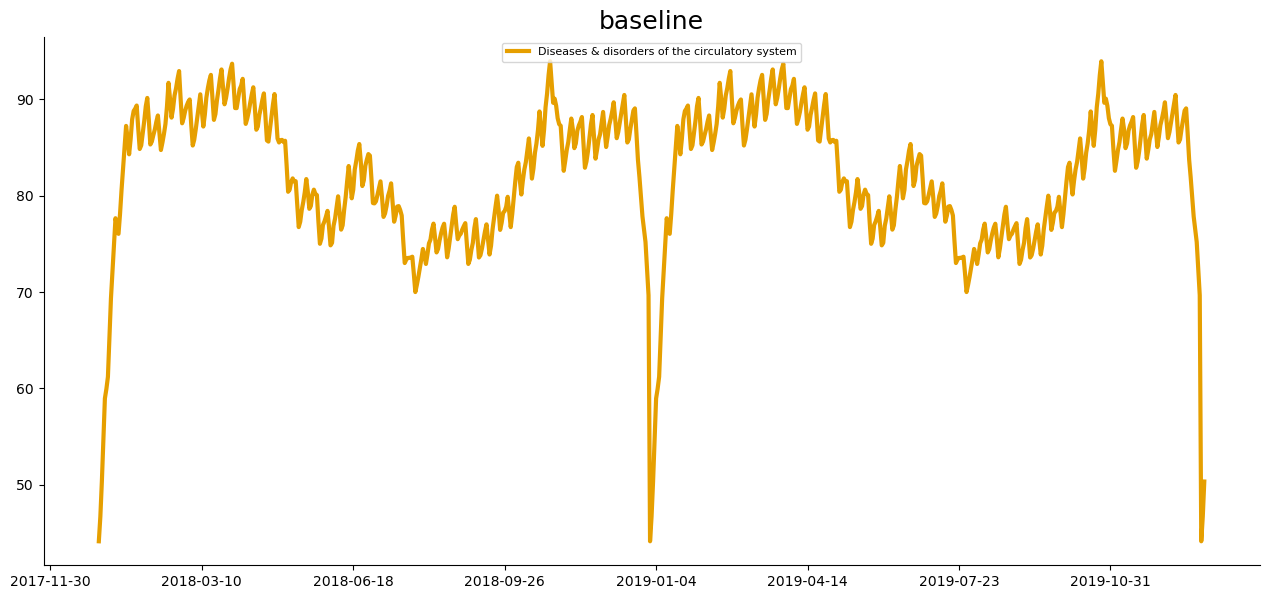

In [ ]:
fix,ax=plt.subplots()

for disease in MDC_plot_classes:

    out_plot = pd.Series(index=time)
    for idx, t in enumerate(time):
        week=t.isocalendar().week
        day=t.isocalendar().weekday
        out_plot[idx] = hospitalization_baseline.loc[disease,week,day]
    out_plot = pd.DataFrame(out_plot)
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('baseline')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

## Covid

### Parameters

In [ ]:
#set start and end date
start_date = pd.to_datetime('2020-06-01')
end_date = pd.to_datetime('2021-03-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

In [ ]:
# Define MDC classes to model
MDC = hospitalizations_per_day_before.index.get_level_values('APR_MDC_key').unique().values
MDC = np.append(MDC,'covid')

# Define model parameters, initial states and coordinates
gamma = mean_residence_times.loc[MDC].values
epsilon = np.ones(len(MDC))*0.01
sigma = np.ones(len(MDC))
sigma[np.where(MDC=='covid')]=10
f_UZG = 0.5

X_tot = 1049

t_string = start_date.strftime('%Y-%m-%d')
covid_H_in = df_covid_H_in.loc[t_string]*f_UZG
covid_H = df_covid_H_tot.loc[t_string]*f_UZG
H_init = hospitalization_baseline.loc[(MDC,start_date.isocalendar().week,start_date.isocalendar().weekday)].values
H_init = np.insert(H_init,np.where(MDC=='covid')[0],covid_H)
A = H_init/mean_residence_times

params={'A':A,'X_tot':X_tot, 'gamma':gamma, 'epsilon':epsilon, 'sigma':sigma,'MDC':MDC,'f_UZG':f_UZG}

init_states = {'H':H_init}
coordinates={'MDC':MDC}
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'A': daily_hospitalizations_func})

C:\Users\wolfd\AppData\Local\Temp\ipykernel_26052\3633951032.py:17: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  H_init = hospitalization_baseline.loc[(MDC,start_date.isocalendar().week,start_date.isocalendar().weekday)].values


### simulate model

In [ ]:
out_real_world_covid = model.sim([start_date,end_date],tau=1)

performing discrete timestepping with tau = 1

[ 5.38065658  8.35303001 31.19699504  2.28235215  5.51432659 14.53204632
 17.67007186 12.96257679  7.40475691 18.57782325  3.92879067  4.75026303
  7.44132957  0.96775021  2.14802065  3.76728552  9.97949469  6.52153596
  8.34354888  7.0354071   3.32790201  0.78492252  1.24930786  3.0898706
  3.46422846  0.10368964  1.3465225   1.56359355  0.        ]
[ 5.38065658  8.35303001 31.19699504  2.28235215  5.51432659 14.53204632
 17.67007186 12.96257679  7.40475691 18.57782325  3.92879067  4.75026303
  7.44132957  0.96775021  2.14802065  3.76728552  9.97949469  6.52153596
  8.34354888  7.0354071   3.32790201  0.78492252  1.24930786  3.0898706
  3.46422846  0.10368964  1.3465225   1.56359355  0.        ]
[ 5.38065658  8.35303001 31.19699504  2.28235215  5.51432659 14.53204632
 17.67007186 12.96257679  7.40475691 18.57782325  3.92879067  4.75026303
  7.44132957  0.96775021  2.14802065  3.76728552  9.97949469  6.52153596
  8.34354888  7.0354071   3.

In [ ]:
out = out_real_world_covid.copy()

In [ ]:
MDC = np.append(MDC,'covid')

### plot results

In [ ]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-06-01')
plot_end_date = pd.to_datetime('2021-03-01')
time = pd.date_range(plot_start_date,plot_end_date)
out = out_real_world_covid.sel(date=time).copy()

#### States

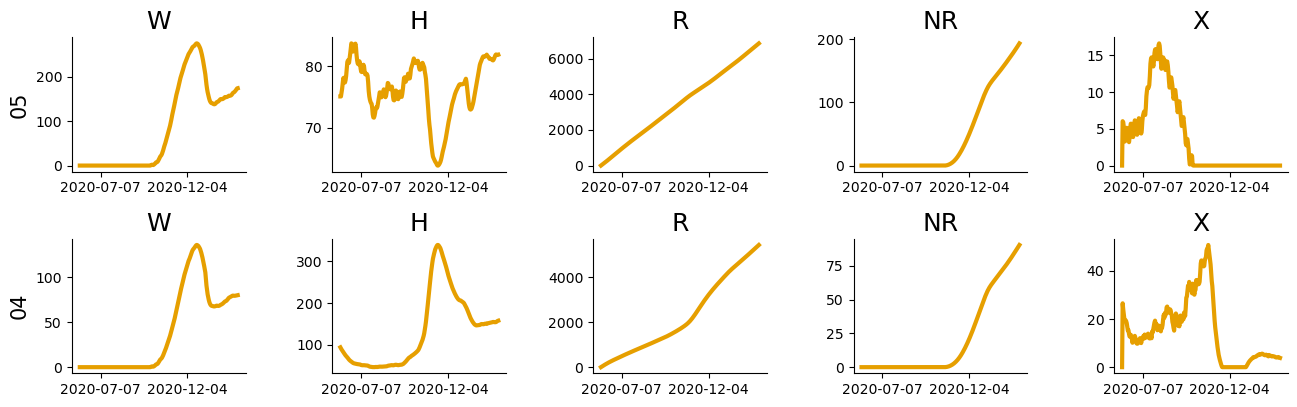

In [ ]:
fig, axs = plt.subplots(len(MDC_plot_classes),5)

for disease_idx, disease in enumerate(MDC_plot_classes):
    axs[disease_idx,0].set_ylabel(disease)
    for state_idx, state in enumerate(model.state_names):
        if disease=='04':
            out_plot = out.sel(MDC=disease)[state]+out.sel(MDC='covid')[state]
        else:
            out_plot = out.sel(MDC=disease)[state].copy()
        axs[disease_idx,state_idx].plot(time,out_plot, label=MDC_dict[disease])
        axs[disease_idx,state_idx].set_title(state)
        axs[disease_idx,state_idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[disease_idx,state_idx].grid(False)
        axs[disease_idx,state_idx].tick_params(axis='both', which='major', labelsize=10)
        axs[disease_idx,state_idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)

#### sum

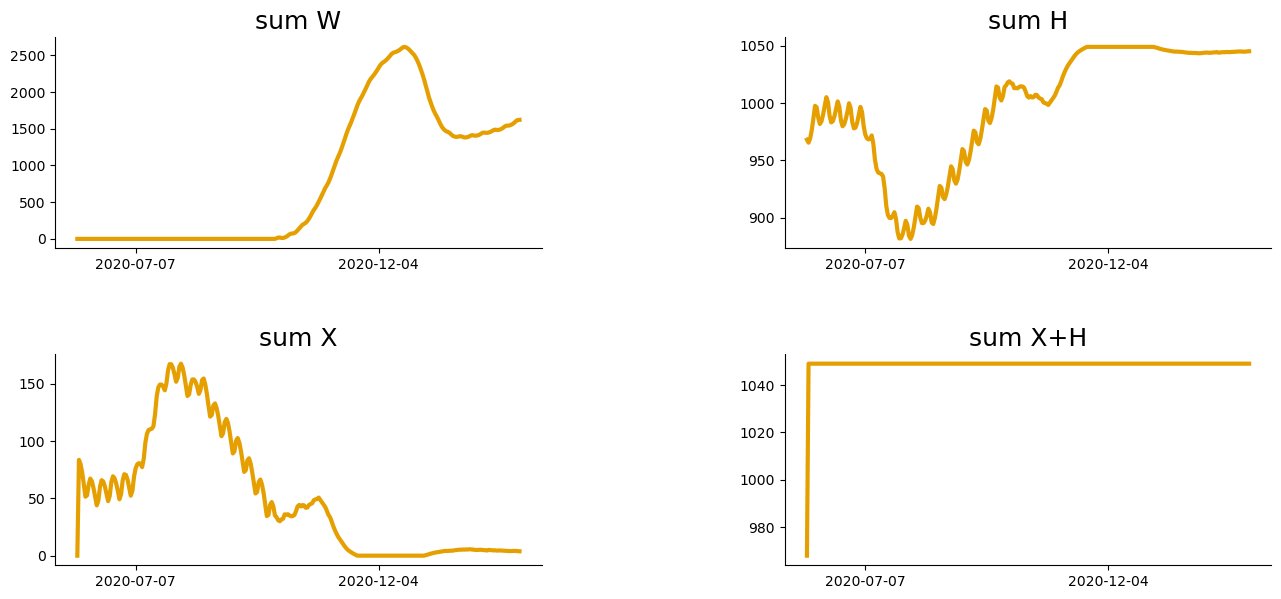

In [ ]:
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for idx,state in enumerate(['W','H','X','X+H']):
    if state == 'X+H':
        out_plot = out.sum('MDC')['X'] + out.sum('MDC')['H']
    else:
        out_plot = out.sum('MDC')[state]
    axs[idx].plot(time,out_plot)
    axs[idx].set_title('sum '+state)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_yticks

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

#### Normalized

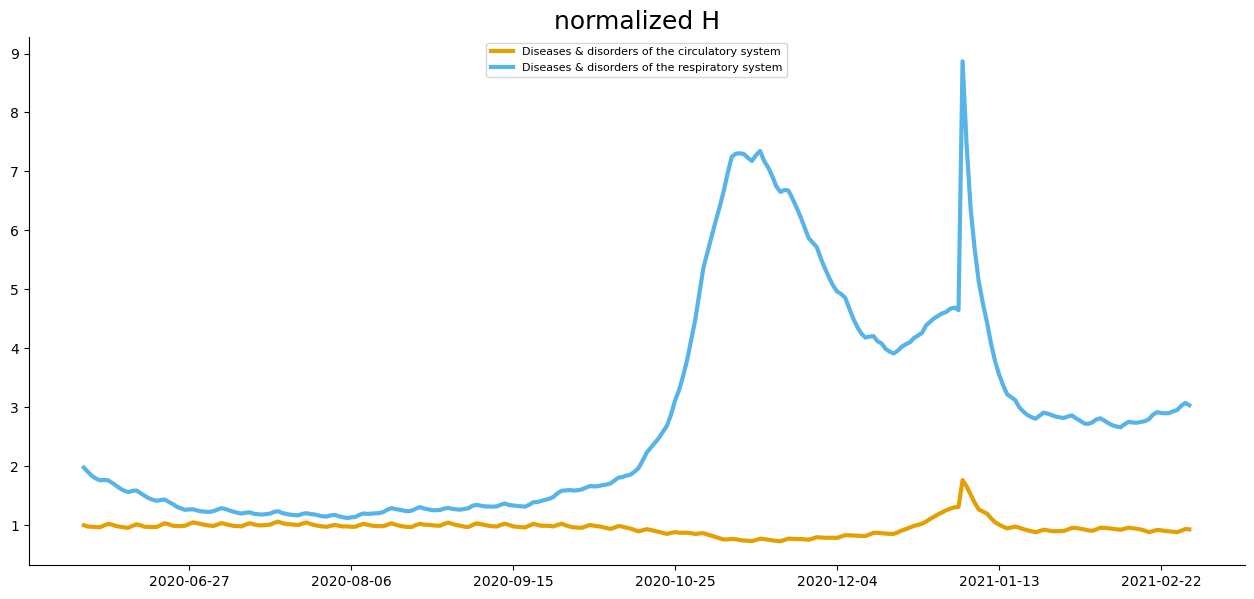

In [ ]:
fix,ax=plt.subplots()

for disease in MDC_plot_classes:
    if disease=='04':
        out_plot = out.sel(MDC=disease)['H']+out.sel(MDC='covid')['H'].values
    else:
        out_plot = out.sel(MDC=disease)['H'].copy().values

    for idx, t in enumerate(time):
        week=t.isocalendar().week
        day=t.isocalendar().weekday
        out_plot[idx] = out_plot[idx]/hospitalization_baseline.loc[disease,week,day]
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    ax.plot(time,out_plot, label=MDC_dict[disease])
    ax.set_title('normalized H')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()

#### covid_H

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


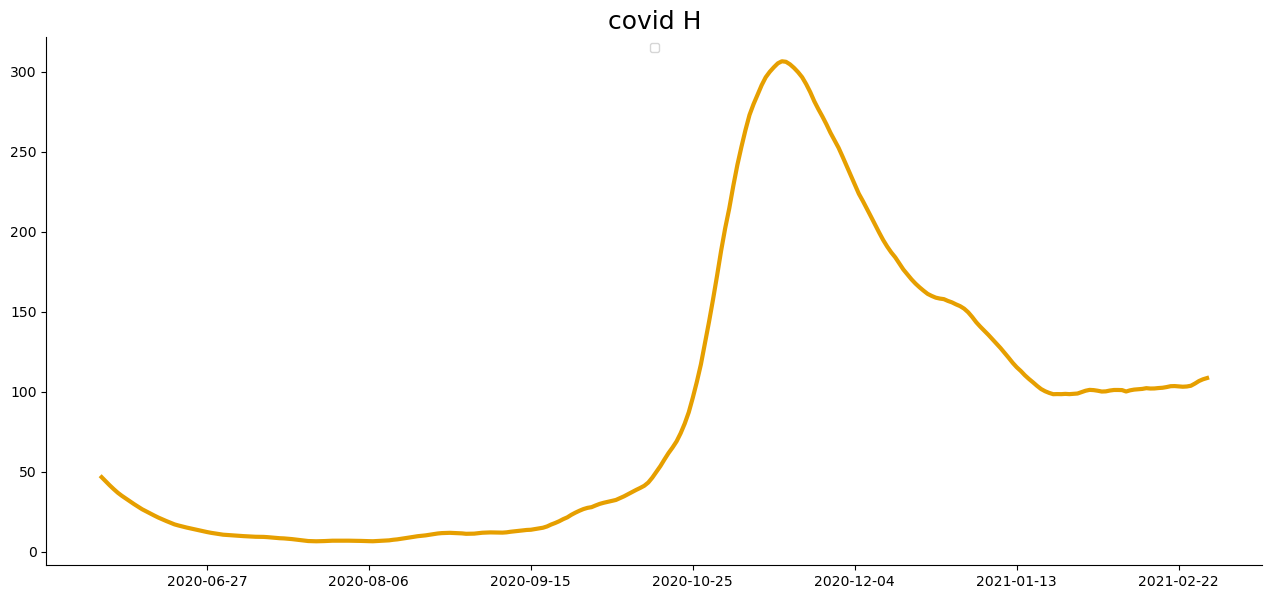

In [ ]:
fix,ax=plt.subplots()

ax.plot(time,out_real_world_covid.sel(MDC='covid')['H'])
ax.set_title('covid H')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.legend(fontsize=8,loc='upper center')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.5)
plt.show()